<h2><strong>Ship Satellite Image Classification Using InceptionV3 Transfer Learning Algorithm</strong></h2>

<strong>Trainee:</strong> Mesuga, Reymond R.


##<h3><strong>Mounting the Google Drive<strong></h3>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install split-folders

##<h3><strong>Importing Necessary Packages<strong></h3>

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
import cv2
import imutils as imutils
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import splitfolders

from tensorflow.keras.applications import inception_v3

from tensorflow.keras.applications.inception_v3 import InceptionV3


RANDOM_SEED = 42 # To make the outputs reproducible
IMG_SIZE = (80,80) # Given size of the images

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

##<h3><strong>About the Dataset</strong></h3><br>
The dataset that will be used in this exercise is from a Kaggle repository named <a href="https://www.kaggle.com/rhammell/ships-in-satellite-imagery">Ships in Satellite Imagery</a>. This dataset contains image chips extracted from <a href="https://www.planet.com/">Planet Satellite Imagery</a> collected over the San Francisco Bay and San Pedro Bay areas of California. The total number of images in the dataset is 6400 with the size of 80x80 pixels which can be classified as ship or no-ship.

##<h3><strong>Splitting the Dataset</strong></h3><br>
The dataset will be splitted into three folders namely train, val, and test folder. The `train` folder contains the 80% of the images which will be used to train the algorithm. The `val` folder contains the images that will be used for hyperparameter tuning. While `test` folder contains the images that will be used to compute the final accuracy of the model.

<table>
  <tr>
  <th></th>
  <th>Training Set</th>
  <th>Validation Set</th>
  <th>Test Set</th>
  </tr>
  <tr>
  <td>ship</td>
  <td>800</td>
  <td>100</td>
  <td>100</td>
  </tr>
  <tr>
  <td>no-ship</td>
  <td>2400</td>
  <td>300</td>
  <td>300</td>
  </tr>
</table>

In [ ]:
%%time
!mkdir Splitted_Dataset
input_folder_path = "/content/drive/MyDrive/Personal-Project-Datasets/shipsnet"
output_folder_path = "Splitted_Dataset"
splitfolders.ratio(input_folder_path, output=output_folder_path, seed=42, ratio=(.8, .1, .1), group_prefix=None) # default values

Copying files: 4000 files [10:50,  6.15 files/s]

CPU times: user 15.8 s, sys: 6.78 s, total: 22.5 s
Wall time: 10min 51s


In [ ]:
Training_Path = "/content/Splitted_Dataset/train/"
Validation_Path = "/content/Splitted_Dataset/val/"
Test_Path = "/content/Splitted_Dataset/test/"
os.listdir(Training_Path)

['ship', 'no-ship']

In [ ]:
def number_of_imgs(path):
  print(path)
  for value in os.listdir(path):
    print(value, "has", len(os.listdir(path + value)), "img", "\n")
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/Splitted_Dataset/test/
ship has 100 img 

no-ship has 300 img 

/content/Splitted_Dataset/train/
ship has 800 img 

no-ship has 2400 img 

/content/Splitted_Dataset/val/
ship has 100 img 

no-ship has 300 img 



##<h3><strong>Data Visualization</strong></h3>

The codes below can randomly generate images from the folder of Training Set, Validation Set and Test Set.

In [ ]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if ship then set it to 1 else 0
            ship = 1 if value == "ship" else 0
            data.append({"path": file_path, 'ship': ship})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

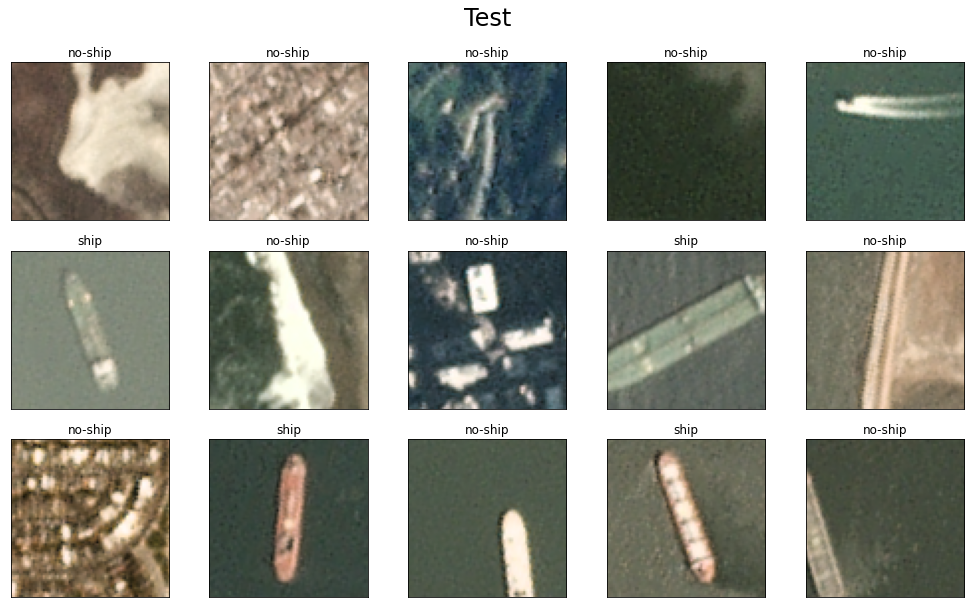

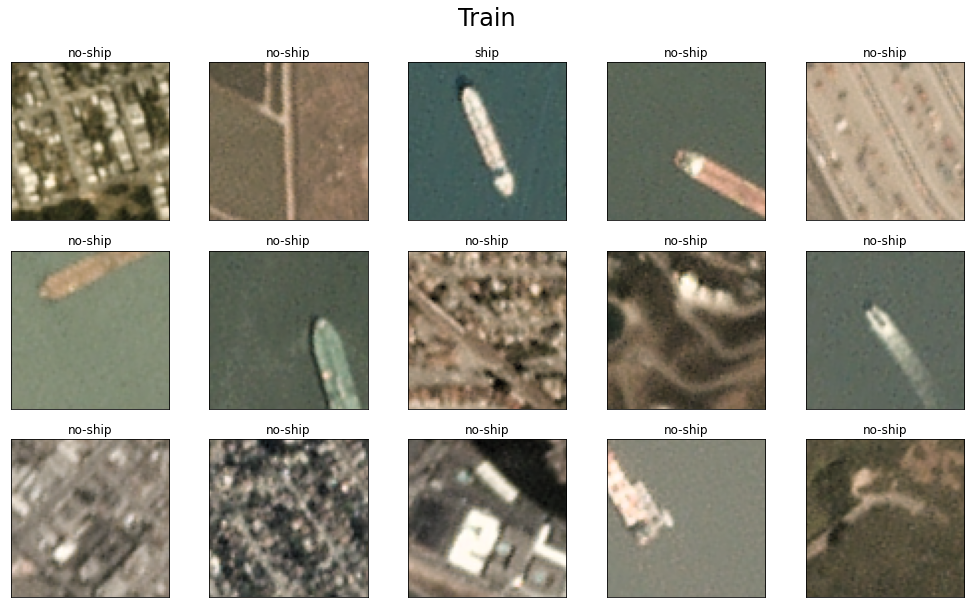

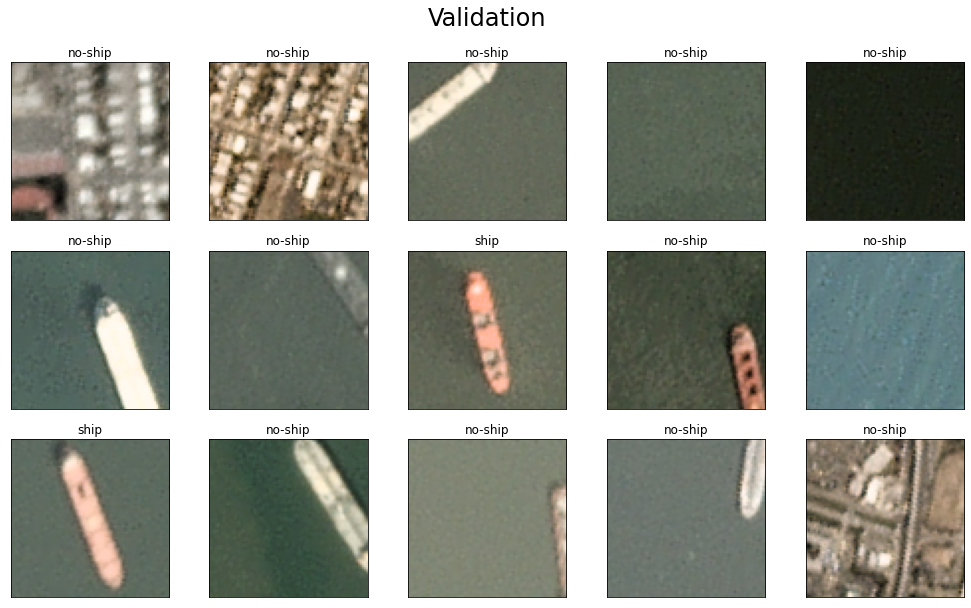

CPU times: user 3.7 s, sys: 331 ms, total: 4.03 s
Wall time: 3.75 s


In [ ]:
%%time
% matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'ship' if row['ship'] == 1 else 'no-ship'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

##<h3><strong>Creating Data Generators</strong></h3><br>
Data generators or `datagens` enables us to feed the data into the model in batches and let the model study or classify the data in batches. This practice is very helpful to save a lot of memory during training.

In [ ]:
%%time
reset_random_seeds()
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=14,
    class_mode='binary',
    seed=RANDOM_SEED
)
validation_generator = val_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=7,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
CPU times: user 139 ms, sys: 4.6 ms, total: 143 ms
Wall time: 342 ms


##<h3><strong>Model Building, Training and Evaluation</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
Helper functions are useful to avoid unnecessary repetitions of the code and make the source code more modular.

####<h5><strong>Helper Function for Building the Model</strong></h5>

In [ ]:
%%time
def model_builder(keras_model, droupout_rate, dense_node, activation_type, learning_rate):
  """
  keras_model = any model that can be imported from Keras applications.
  droupout_rate = Float between 0 and 1. Fraction of the input units to drop.
  dense_node = represents the number of units (neurons)
  activation_type = represent activation to be used
  learning_rate = A Tensor, floating point value. Defaults to 0.001.
  """
  reset_random_seeds()
  
  base_model = keras_model(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
  )

  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Dropout(droupout_rate))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(dense_node,activation=activation_type))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.layers[0].trainable = False

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      metrics=['accuracy']
  )

  model.summary()
  return model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


####<h5><strong>Helper Function for Training the Model</strong></h5>

In [ ]:
%%time
def model_trainer(model, epochs):
  """
  model = represents the model built using the function `model_builder`.
  epochs = defines the number times that the learning algorithm will work through the entire training dataset
  """
  reset_random_seeds()
  
  EPOCHS = epochs
  
  history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=25,
  )
  print("Training Done")
  model_training_history = {"history": history,
                   "model": model
                   }
  return model_training_history

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


####<h5><strong>Helper Function for Visualization of the Training Results</strong></h5>

In [ ]:
def training_result_visualizer(Training_History):
  """
  Training_History = e.g., Training_History_VGG16["history"]
  """
  reset_random_seeds()
  
  %matplotlib inline
  acc = Training_History.history["accuracy"]
  val_acc = Training_History.history["val_accuracy"]
  loss = Training_History.history["loss"]
  val_loss = Training_History.history["val_loss"]

  epochs_range = range(1, len(Training_History.epoch)+1)

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model Loss')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Validation and Test Accuracy</strong></h5>

In [ ]:
%%time
def Accuracy_Score(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.inception_v3.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  print("Accuracy:", accuracy)

  # Confusion Matrix
  confusion_mtx = confusion_matrix(reality, predictions)
  
  ax = plt.axes()
  sn.heatmap(confusion_mtx, annot=True, annot_kws={"size": 25}, cmap="Blues", ax=ax)
  ax.set_title('Confusion Matrix', size=14)
  plt.show() 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


###<h5><strong>InceptionV3: Defining the Model</strong></h5>

In [ ]:
%%time
Model_InceptionV3 = model_builder(InceptionV3, droupout_rate=0.5, dense_node=512, activation_type="relu", learning_rate=0.001)
Model_InceptionV3

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-

###<h5><strong>InceptionV3: Training the Model</strong></h5>

In [ ]:
%%time
Training_History_InceptionV3 = model_trainer(Model_InceptionV3, epochs=20)
Training_History_InceptionV3

Epoch 1/20
50/50 [==============================] - 38s 98ms/step - loss: 0.3596 - accuracy: 0.8643 - val_loss: 0.1851 - val_accuracy: 0.9200
Epoch 2/20
50/50 [==============================] - 3s 54ms/step - loss: 0.2124 - accuracy: 0.9171 - val_loss: 0.1768 - val_accuracy: 0.9371
Epoch 3/20
50/50 [==============================] - 3s 51ms/step - loss: 0.2069 - accuracy: 0.9300 - val_loss: 0.1518 - val_accuracy: 0.9429
Epoch 4/20
50/50 [==============================] - 3s 66ms/step - loss: 0.1887 - accuracy: 0.9323 - val_loss: 0.1575 - val_accuracy: 0.9371
Epoch 5/20
50/50 [==============================] - 3s 51ms/step - loss: 0.1846 - accuracy: 0.9409 - val_loss: 0.1798 - val_accuracy: 0.9371
Epoch 6/20
50/50 [==============================] - 3s 53ms/step - loss: 0.1512 - accuracy: 0.9429 - val_loss: 0.1956 - val_accuracy: 0.9371
Epoch 7/20
50/50 [==============================] - 3s 53ms/step - loss: 0.1897 - accuracy: 0.9251 - val_loss: 0.2334 - val_accuracy: 0.9257
Epoch 8/20
5

###<h5><strong>InceptionV3: Visualization of the Training Results</strong></h5>

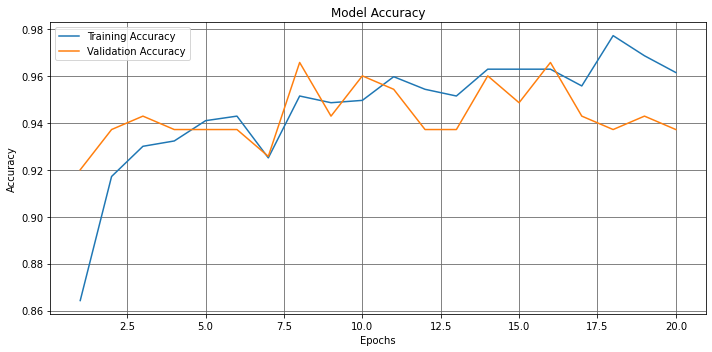

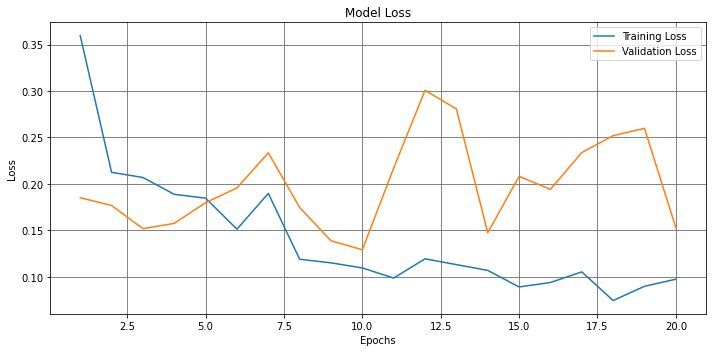

In [ ]:
InceptionV3_Training_Results = training_result_visualizer(Training_History_InceptionV3["history"])
InceptionV3_Training_Results

###<h5><strong>InceptionV3: Validation Accuracy</strong></h5>


Accuracy: 0.95


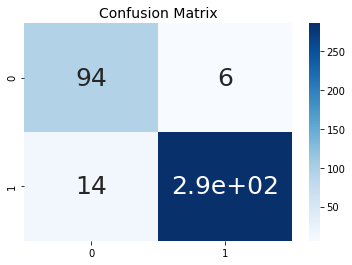

CPU times: user 3.92 s, sys: 206 ms, total: 4.13 s
Wall time: 4.56 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_InceptionV3["model"])

##<h3><strong>Hyperparameter Tuning: Improving the Model</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
The helper functions here in hyperparameter tuning generates the plotted accuracy of different values of hyperparameter. This is to visualize better the performance of different values of hyperparameter and ease decision making.

####<h5><strong>Helper Function for Changing Dropout Rate</strong></h5>

In [ ]:
def Accuracy_Score_for_Tuning(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.inception_v3.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  return accuracy

In [ ]:
%%time
def param_tuning_with_dropout( keras_model, dropout_rates ):
  reset_random_seeds()
  Accuracy = []
  for rate in dropout_rates:
    reset_random_seeds()
    Model = model_builder(keras_model, rate, dense_node=512, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")
    print("Dropout Rate: ", rate)
  
    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)

  print("This is the plot of the recorded Accuracy per Droupout Rate")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Dropout")
  plt.plot(dropout_rates, Accuracy, 'r-o')
  plt.xlabel("Dropout Rate")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()
  

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


####<h5><strong>Helper Function for Changing Activation Type</strong></h5>

In [ ]:
def param_tuning_with_activation( keras_model, activation_types ):
  reset_random_seeds()
  Accuracy = []
  for type in activation_types:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=512, activation_type=type, learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Activation Type: ", type)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Activation Type")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Activation")
  plt.plot(activation_types, Accuracy, 'r-o')
  plt.xlabel("Activation")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Changing Number of Node</strong></h5>

In [ ]:
%%time
def param_tuning_with_Nodes( keras_model, set_of_nodes ):
  reset_random_seeds()
  Accuracy = []
  for nodes in set_of_nodes:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=nodes, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Number of Nodes: ", nodes)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Nodes")
  plt.plot(set_of_nodes, Accuracy, 'r-o')
  plt.xlabel("No. of Node")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


####<h5><strong>Helper Function for Testing No. of Epochs</strong></h5>

In [ ]:
%%time
def param_tuning_with_Epochs( keras_model, epoch_value ):
  reset_random_seeds()
  
  Model = model_builder(keras_model, droupout_rate=0.5, dense_node=512, activation_type="relu", learning_rate=0.001)

  Training_History_Model = model_trainer(Model, epochs=epoch_value)
  Training_History_Model
  print("_________________________________________________________________")

  print("Number of Epochs: ", epoch_value)

  Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
  Model_Training_Results
  

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


###<h3><strong>Changing Dropout Rate</strong></h3>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

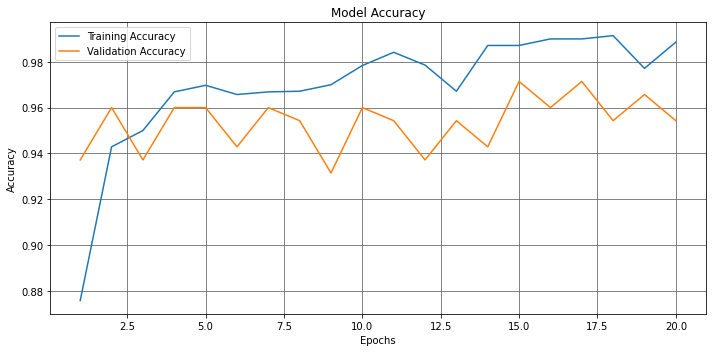

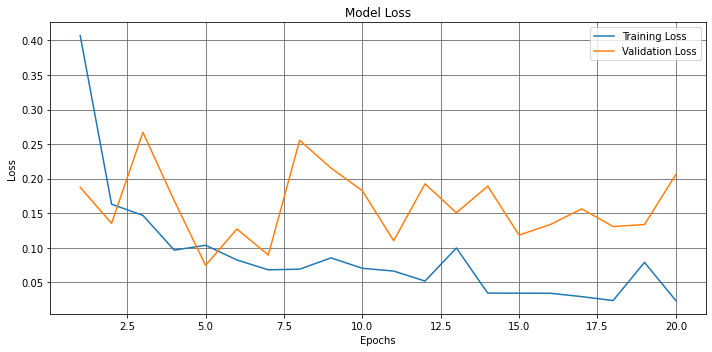

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_284 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

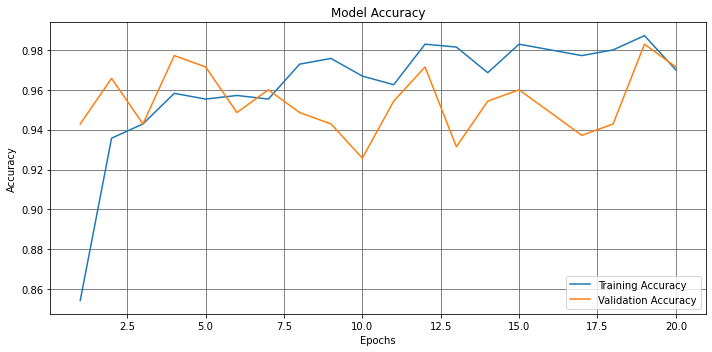

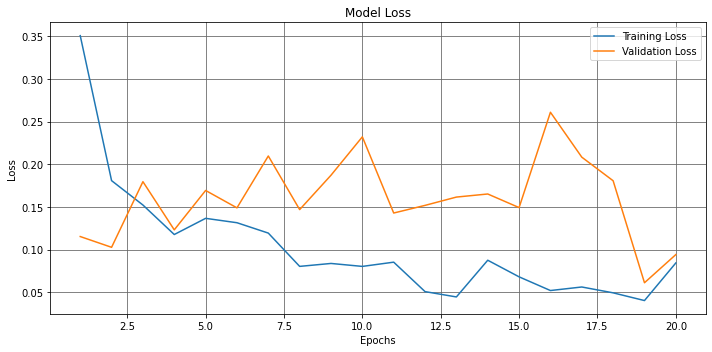

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_379 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

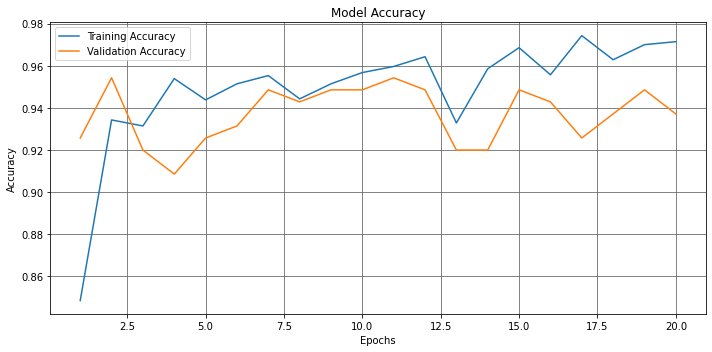

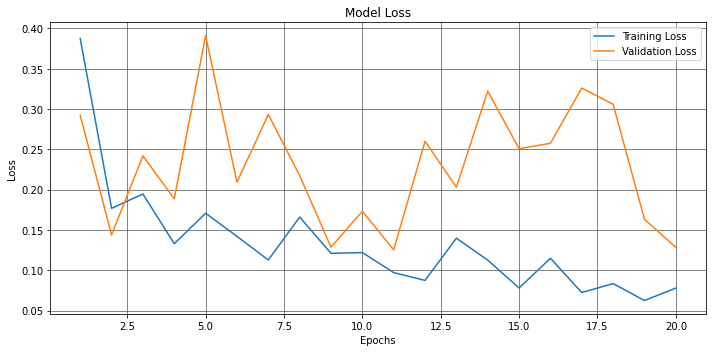

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_474 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

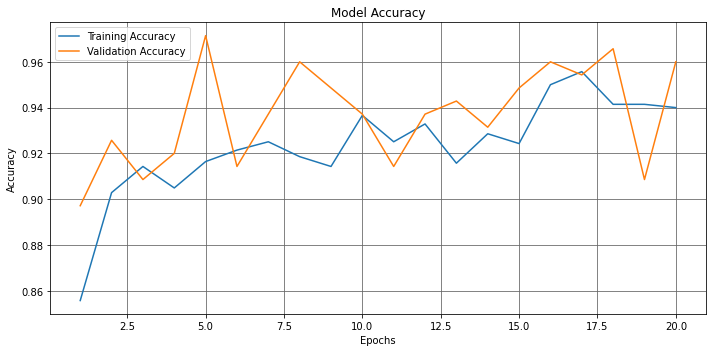

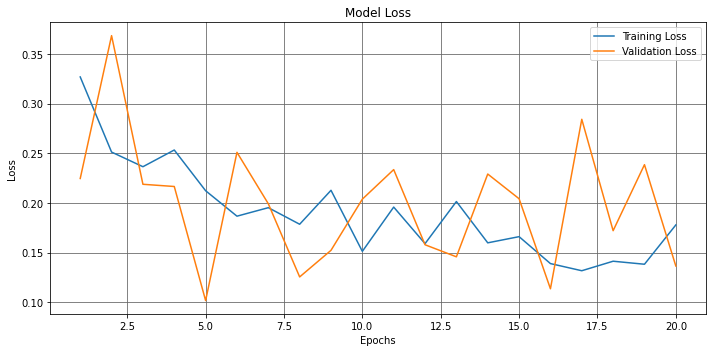

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_569 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

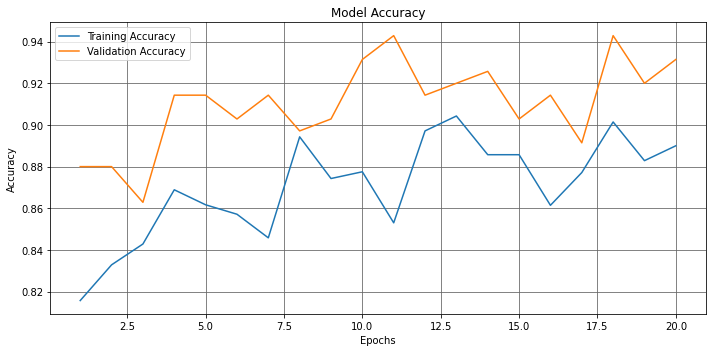

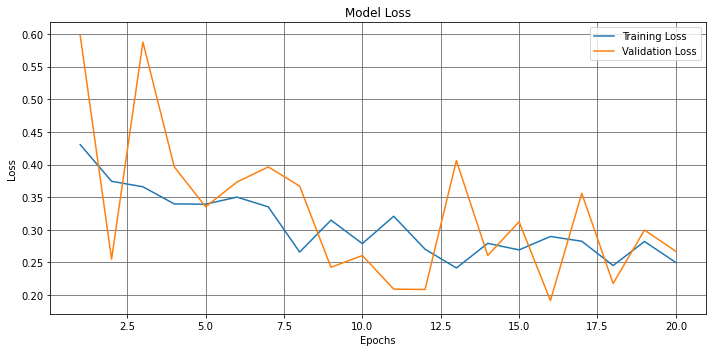

This is the plot of the recorded Accuracy per Droupout Rate
[0.945, 0.9325, 0.9375, 0.9575, 0.9325]


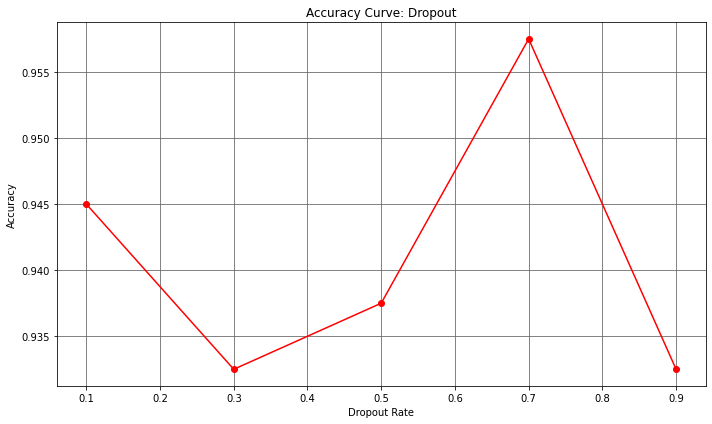

CPU times: user 5min 48s, sys: 17.1 s, total: 6min 5s
Wall time: 7min 36s


In [ ]:
%%time
param_tuning_with_dropout( InceptionV3, dropout_rates=[0.1, 0.3, 0.5, 0.7, 0.9])

###<h3><strong>Changing Activation Type</strong></h3>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_664 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

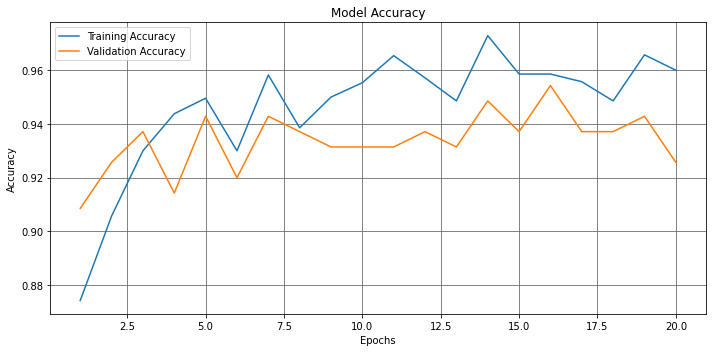

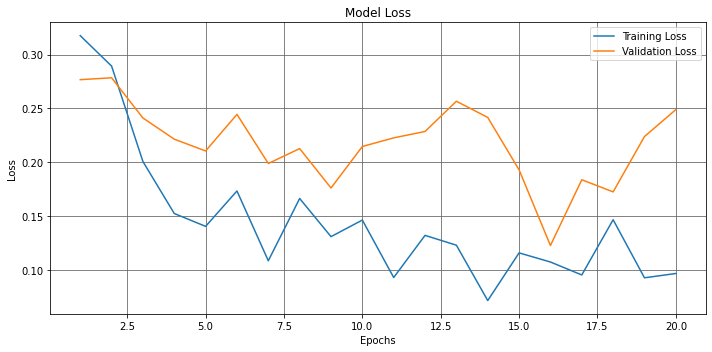

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_759 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

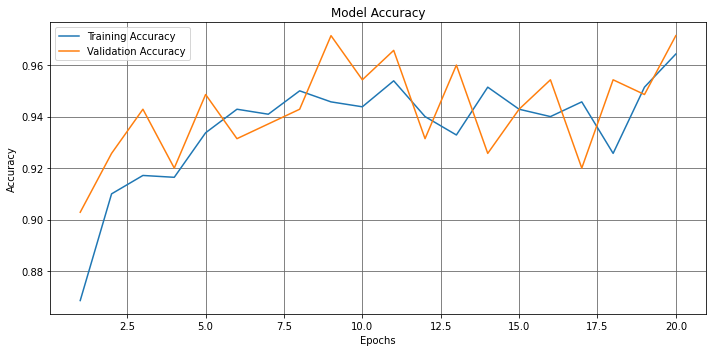

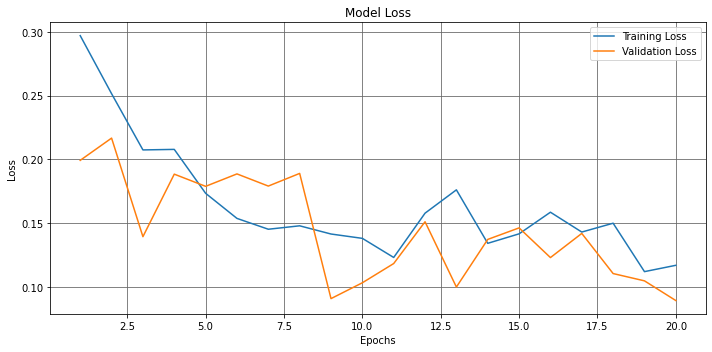

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_854 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

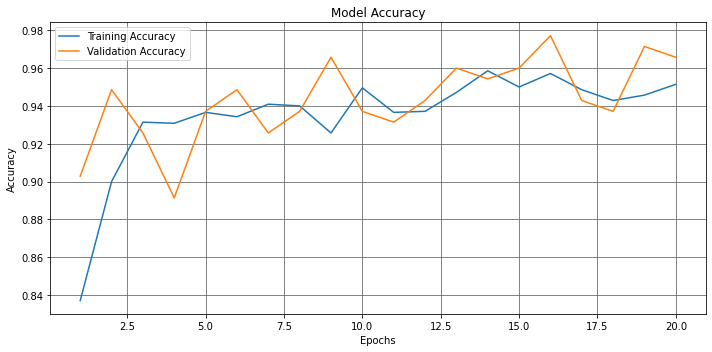

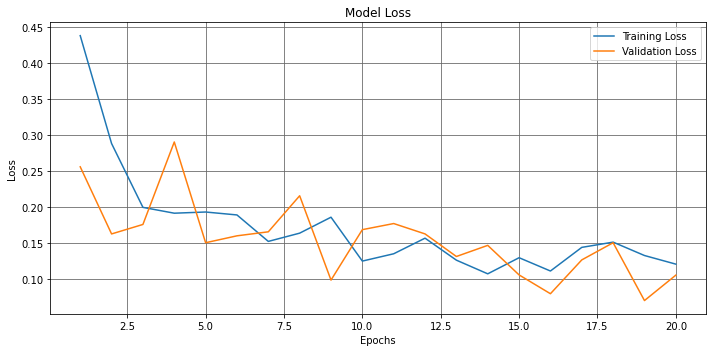

This is the plot of the recorded Accuracy per Activation Type
[0.9375, 0.96, 0.94]


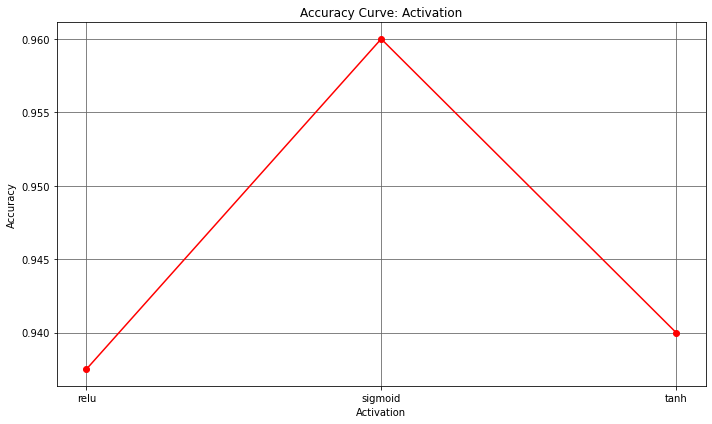

CPU times: user 3min 25s, sys: 9.82 s, total: 3min 35s
Wall time: 4min 50s


In [ ]:
%%time
param_tuning_with_activation( InceptionV3, activation_types=["relu","sigmoid","tanh"] )

###<h3><strong>Changing the No. of Nodes</strong></h3>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_949 (Bat (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
__________________________________

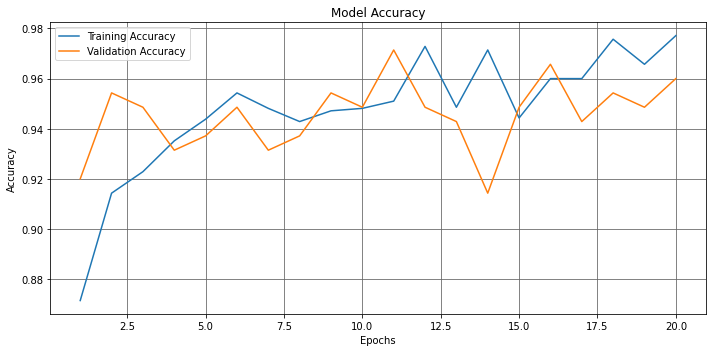

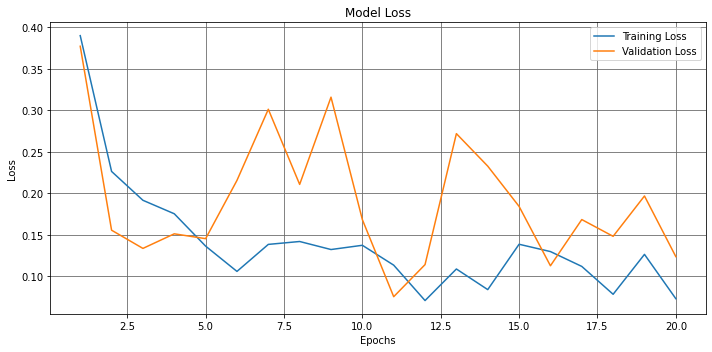

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_1044 (Ba (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 1025      
Total params: 23,910,177
Trainable params: 2,103,297
Non-trainable params: 21,806,880
_________________________________

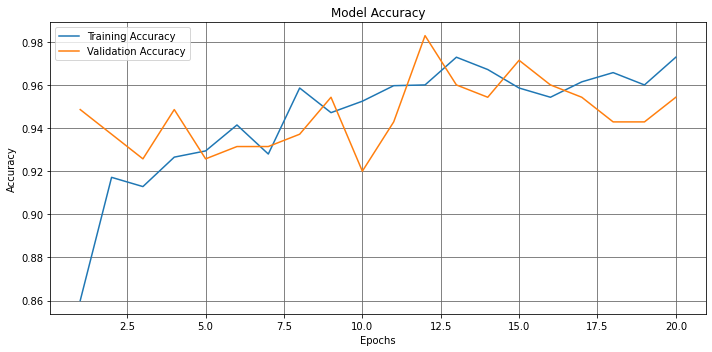

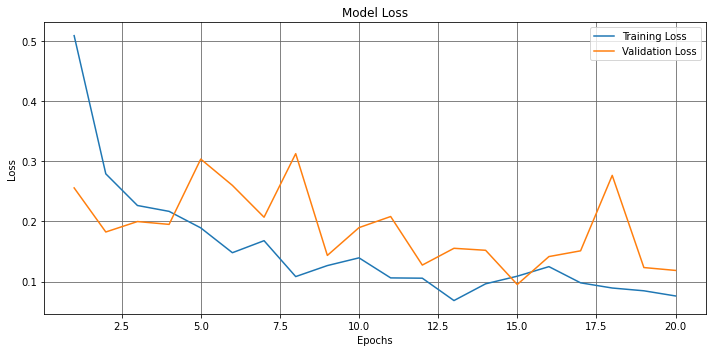

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_1139 (Ba (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 2049      
Total params: 26,009,377
Trainable params: 4,202,497
Non-trainable params: 21,806,880
_________________________________

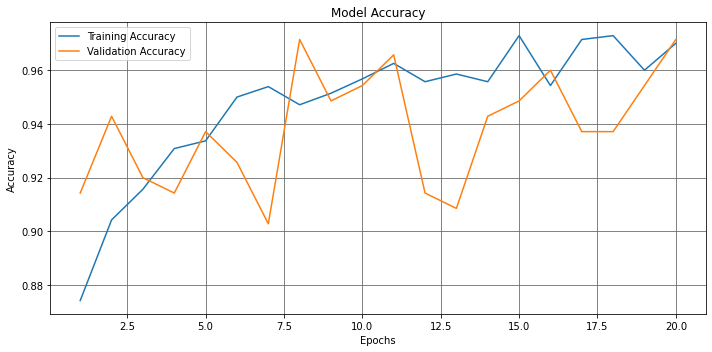

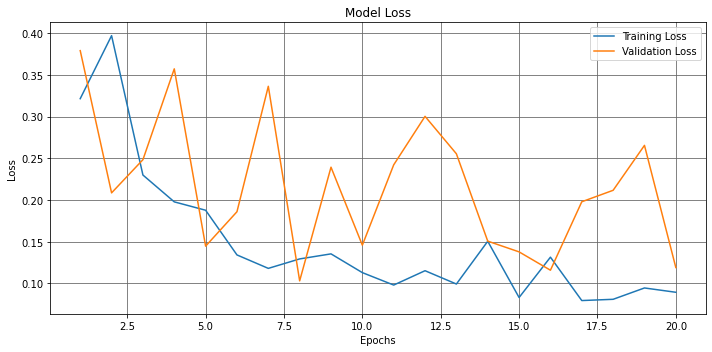

This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model
[0.945, 0.935, 0.9575]


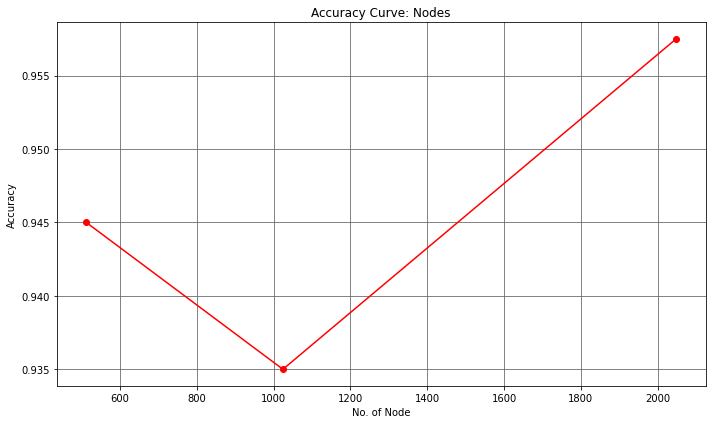

CPU times: user 3min 23s, sys: 9.61 s, total: 3min 33s
Wall time: 4min 43s


In [ ]:
%%time
param_tuning_with_Nodes( InceptionV3, set_of_nodes = [512,1024,2048] )

###<h3><strong>Testing with Epochs</strong></h3>

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_1519 (Ba (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_15 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
_________________________________

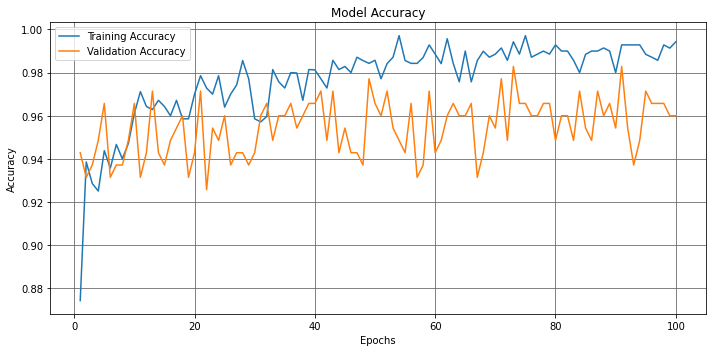

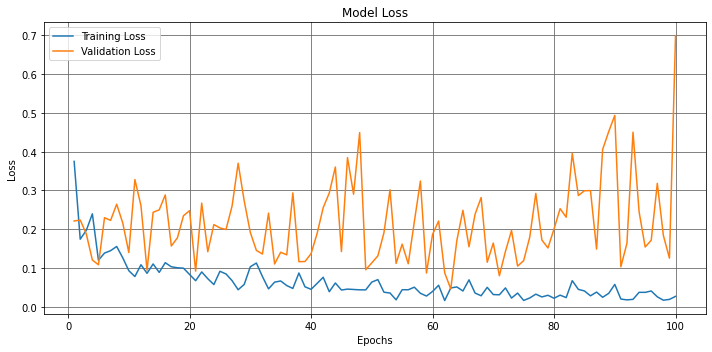

In [ ]:
param_tuning_with_Epochs( InceptionV3, epoch_value=100 )

###<h3><strong>Building the Best Model with Optimum Values of Hyperparameter</strong></h3><br>

The hyperparameters that have been tested for tuning are as follows: <strong>Dropout Rate</strong>, <strong>Activation</strong> in the hidden layers, and the No. of <strong>Nodes</strong> in the head of the model.

The default values of hyperparameters of the baseline model are as follows:
<ul>
<li>dropout_rate = 0.5</li>
<li>dense_node = 512</li>
<li>activation = "relu"</li>
<li>epochs = 20</li>
</ul>

which gives an <strong>accuracy = 0.95</strong> in the validation set.

On the other hand, during the hyperparameter tuning, it is observed that the optimum values for the said hyperparameters are as follows.

<ul>
<li>dropout_rate = 0.7</li>
<li>dense_node = 2048</li>
<li>activation = "sigmoid"</li>
<li>epochs = 91</li>
</ul>

which gives the accuracy of <strong>0.9575</strong>, <strong>0.9575</strong>, <strong>0.96</strong>, and <strong>0.9829</strong> respectively. So these are the values that we will be using to improve the performance of the model. 



In [ ]:
%%time
Tuned_Model_InceptionV3 = model_builder(InceptionV3, droupout_rate=0.7, dense_node=512, activation_type="sigmoid", learning_rate=0.001)
Tuned_Model_InceptionV3

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
batch_normalization_2184 (Ba (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_22 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 513       
Total params: 22,860,577
Trainable params: 1,053,697
Non-trainable params: 21,806,880
_________________________________

In [ ]:
%%time
Training_History_TunedInceptionV3 = model_trainer(Tuned_Model_InceptionV3, epochs=20)
Training_History_TunedInceptionV3

Epoch 1/20
50/50 [==============================] - 10s 86ms/step - loss: 0.3782 - accuracy: 0.8286 - val_loss: 0.2055 - val_accuracy: 0.8971
Epoch 2/20
50/50 [==============================] - 3s 53ms/step - loss: 0.2567 - accuracy: 0.8986 - val_loss: 0.2297 - val_accuracy: 0.8971
Epoch 3/20
50/50 [==============================] - 3s 55ms/step - loss: 0.2595 - accuracy: 0.8971 - val_loss: 0.1723 - val_accuracy: 0.9143
Epoch 4/20
50/50 [==============================] - 3s 54ms/step - loss: 0.1933 - accuracy: 0.9265 - val_loss: 0.1899 - val_accuracy: 0.9371
Epoch 5/20
50/50 [==============================] - 3s 55ms/step - loss: 0.2258 - accuracy: 0.9063 - val_loss: 0.1854 - val_accuracy: 0.9314
Epoch 6/20
50/50 [==============================] - 3s 55ms/step - loss: 0.1934 - accuracy: 0.9229 - val_loss: 0.1562 - val_accuracy: 0.9429
Epoch 7/20
50/50 [==============================] - 3s 54ms/step - loss: 0.2248 - accuracy: 0.8963 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 8/20
5

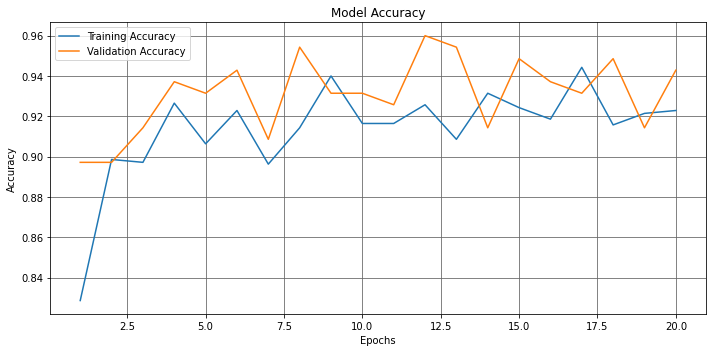

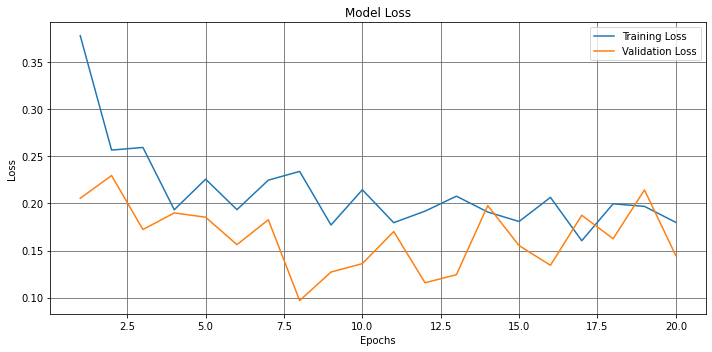

In [ ]:
TunedInceptionV3_Training_Results = training_result_visualizer(Training_History_TunedInceptionV3["history"])
TunedInceptionV3_Training_Results

Accuracy: 0.9525


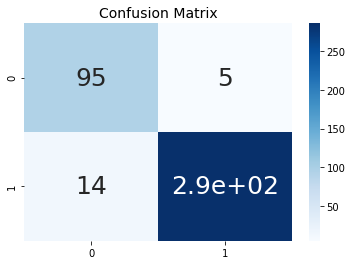

CPU times: user 2.6 s, sys: 158 ms, total: 2.75 s
Wall time: 2.63 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_TunedInceptionV3["model"])

After some trial and error, it turns out that changing the dropout_rate from 0.5 to 0.7 and changing activation from "relu" to "sigmoid" will increase the accuracy of the model from 0.95 to 0.9525. 

##<h3><strong>Applyin the Tuned Model on Test Set for Final Accuracy</strong></h3>

After choosing the best paramater value in hyperparameter tuning, we are now going to test the accuracy of the tuned model on the test set to report the final accuracy.

Accuracy: 0.94


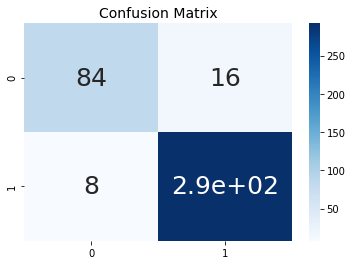

CPU times: user 1.66 s, sys: 129 ms, total: 1.79 s
Wall time: 2.3 s


In [ ]:
%%time
Accuracy_Score(Test_Path, Training_History_TunedInceptionV3["model"])

##<h3><strong>Summary and Conclusion</strong></h3>

The following practices have been performed in this exercise:
<ul>
<li>Splitting the Dataset</li>
<li>Data Visualization</li>
<li>Creating Helper Functions</li>
<li>Building the Model</li>
<li>Training the Model</li>
<li>Evaluating the Model</li>
<li>Hyperparameter Tuning</li>
<li>Testing the Accuracy of the Model on the Test Set</li>
</ul>

<strong>Before Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.95

<strong>After Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.9525

<strong>Final Accuracy</strong><br>
Test Accuracy: 0.94

It is observed that the model achieved a fairly high accuracy of 0.95 on the Validation Set even without highperparameter Tuning. One of the reason for achieving this kind of accuracy is because of the nature of the images. The difference between the images of the two class are very noticeable (see the images below). Even though the model achieved a significanlty high accuracy, it also a good practice to apply hyperparameter tuning to really reach the maximum potential accuracy of the model where it achived 0.9525 accuracy on the Validation Set. Finally, the accuracy of the model on Test Set is 0.94 which indicates that the model really did a good job at classifying ship and no-ship.


<strong>Class: ship</strong>
![](https://i.imgur.com/tLsSoTz.png)
<strong>Class: no-ship</strong>
![](https://i.imgur.com/Q3daQMC.png)